In [376]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

In [377]:
import re

import pandas as pd
import numpy as np

import constants as cons

from PIL import Image
from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.graph_objs as go
import plotly.offline as py
import seaborn as sns

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from lofo import LOFOImportance, Dataset, plot_importance

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [378]:
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep') 

import matplotlib.style as style
style.use('fivethirtyeight')
import time

In [379]:
df = pd.read_csv(cons.file_path, index_col=0)
df_raw = df.copy()

In [380]:
###################################### EXPLORE ######################################

In [381]:
df.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00


In [382]:
df.shape

(84548, 21)

In [383]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84548 entries, 4 to 8413
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         84548 non-null  int64 
 1   NEIGHBORHOOD                    84548 non-null  object
 2   BUILDING CLASS CATEGORY         84548 non-null  object
 3   TAX CLASS AT PRESENT            84548 non-null  object
 4   BLOCK                           84548 non-null  int64 
 5   LOT                             84548 non-null  int64 
 6   EASE-MENT                       84548 non-null  object
 7   BUILDING CLASS AT PRESENT       84548 non-null  object
 8   ADDRESS                         84548 non-null  object
 9   APARTMENT NUMBER                84548 non-null  object
 10  ZIP CODE                        84548 non-null  int64 
 11  RESIDENTIAL UNITS               84548 non-null  int64 
 12  COMMERCIAL UNITS                84548 non-null  int6

<a id='3'></a><center> <h2 style="background-color:green; color:white" ><br>1. DATA CLEANING  <br></h2>

In [384]:
df['BOROUGH'] = df['BOROUGH'].map(cons.borough_encoding)

df['SALE PRICE'] = df['SALE PRICE'].replace({' -  ':'0'})
df['SALE PRICE'] = df['SALE PRICE'].astype(float)

#df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].map(lambda x: year_built(x))
df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].replace({' -  ':'0'})
df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].astype(int)

df['MONTH SOLD'] = df['SALE DATE'].map(lambda x: x[5:7])
df['MONTH SOLD'] = df['MONTH SOLD'].map(lambda x: int(x))
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])
df['YEAR SOLD']= df['SALE DATE'].dt.year
df['BUILDING CLASS CATEGORY'] = df['BUILDING CLASS CATEGORY'].str.strip()

df = df.replace(to_replace=r'^\s*[-]\s*', value=np.nan, regex=True)
map_dict={'-':np.nan,' ':np.nan}
df.replace(map_dict,inplace = True)

for colname in cons.num_cats:
    df[colname] = df[colname].astype('category') 

for colname in cons.obj_cats:
    df[colname] = df[colname].astype('category')  

numer = ['LAND SQUARE FEET','GROSS SQUARE FEET', 'SALE PRICE']
for col in numer: # coerce for missing values
    df[col] = pd.to_numeric(df[col], errors='coerce')

#df.drop(["EASE-MENT", "ADDRESS","APARTMENT NUMBER"], axis=1, inplace=True) # Completely empty columns.
#df.drop(["YEAR BUILT", "LOT","ZIP CODE", "SALE DATE", "BLOCK"], axis=1, inplace=True) # Unnecessary columns.
    
# Dropping index and EASE-MENT
df.drop(['EASE-MENT',
         'APARTMENT NUMBER',
         'ADDRESS'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84548 entries, 4 to 8413
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BOROUGH                         84548 non-null  category      
 1   NEIGHBORHOOD                    84548 non-null  category      
 2   BUILDING CLASS CATEGORY         84548 non-null  category      
 3   TAX CLASS AT PRESENT            83810 non-null  category      
 4   BLOCK                           84548 non-null  category      
 5   LOT                             84548 non-null  category      
 6   BUILDING CLASS AT PRESENT       83810 non-null  category      
 7   ZIP CODE                        84548 non-null  category      
 8   RESIDENTIAL UNITS               84548 non-null  int64         
 9   COMMERCIAL UNITS                84548 non-null  int64         
 10  TOTAL UNITS                     84548 non-null  int64         
 11  LAND SQU

In [385]:
df.columns = df.columns.str.replace(' ', '_')
df.columns= df.columns.str.lower()
df.columns

Index(['borough', 'neighborhood', 'building_class_category',
       'tax_class_at_present', 'block', 'lot', 'building_class_at_present',
       'zip_code', 'residential_units', 'commercial_units', 'total_units',
       'land_square_feet', 'gross_square_feet', 'year_built',
       'tax_class_at_time_of_sale', 'building_class_at_time_of_sale',
       'sale_price', 'sale_date', 'month_sold', 'year_sold'],
      dtype='object')

In [386]:
df['age'] = 2021 - df['year_built']

#is the building pre or post war?
df['age_category'] = np.where(df['age']>=76,'Pre-War','Post-War')

# Convert to Category
df['age_category'] = df['age_category'].astype('category')

In [387]:
df.head()

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,building_class_at_present,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_date,month_sold,year_sold,age,age_category
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,C2,10009,5,0,5,1633.000,6440,1900,2,C2,6625000.000,2017-07-19,7,2017,121,Pre-War
5,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,C7,10009,28,3,31,4616.000,18690,1900,2,C7,0.000,2016-12-14,12,2016,121,Pre-War
6,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,C7,10009,16,1,17,2212.000,7803,1900,2,C7,0.000,2016-12-09,12,2016,121,Pre-War
7,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,C4,10009,10,0,10,2272.000,6794,1913,2,C4,3936272.000,2016-09-23,9,2016,108,Pre-War
8,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,C2,10009,6,0,6,2369.000,4615,1900,2,C2,8000000.000,2016-11-17,11,2016,121,Pre-War


<a id='3'></a><center> <h2 style="background-color:green; color:white" ><br>2.EXPLORATORY DATA ANALYSIS  <br></h2>

<Axes: >

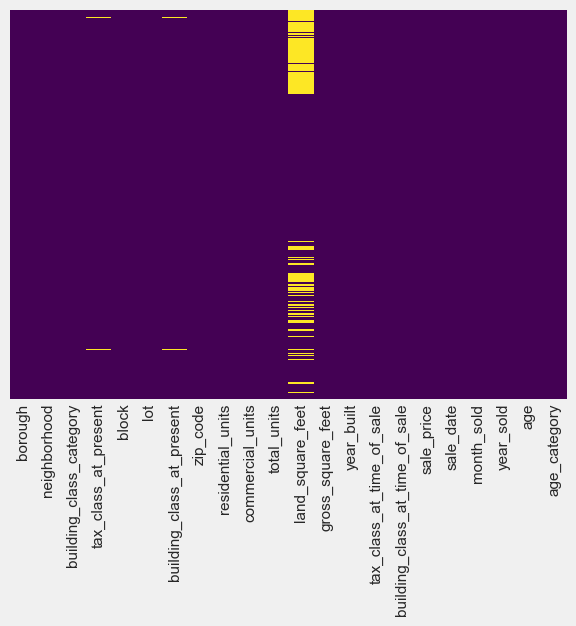

In [388]:
sns.heatmap(
    df.isnull(), 
    yticklabels=False, 
    cbar=False, 
    cmap='viridis'
)

<img src="data/Boroughs_New_York.png" alt="Image caption" width="500" height="200">

<img src="data/Boroughs_New_York_City_Map.png" alt="Image caption" width="400" height="300">

Text(0.5, 1.0, 'Sales per Borough')

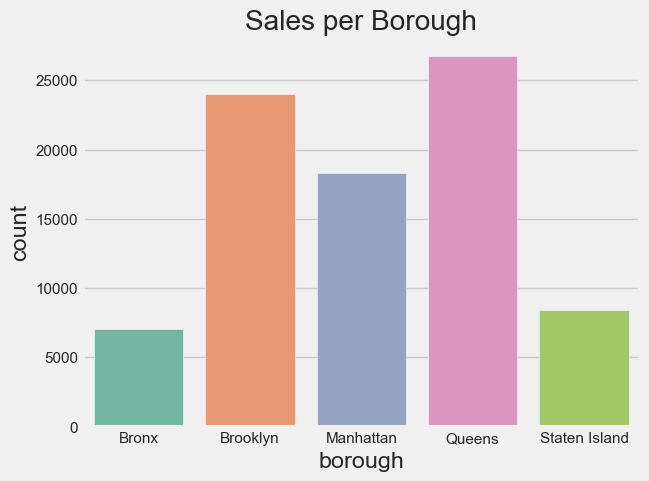

In [389]:
sns.countplot(x='borough', data=df, palette='Set2')
plt.title('Sales per Borough')

# Maximum properties are sold in Queens! followed by Staten Island!

Text(0.5, 1.0, 'Sales per Borough Residential')

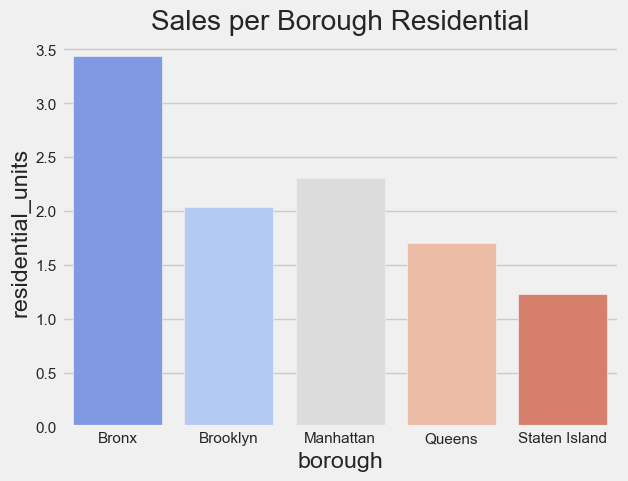

In [390]:
sns.barplot(y='residential_units', x='borough',data=df, palette='coolwarm', ci=None)
plt.title('Sales per Borough Residential')

# Residential Units are mainly sold in ...

Text(0.5, 1.0, 'Sales per Borough Commercial')

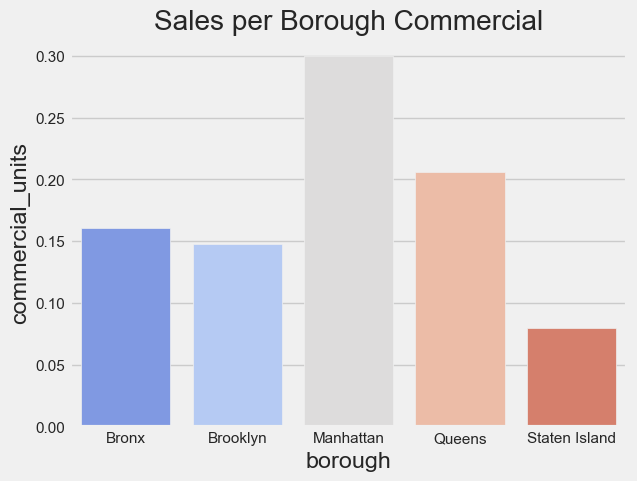

In [391]:
sns.barplot(y='commercial_units', x='borough',data=df, palette='coolwarm', ci=None)
plt.title('Sales per Borough Commercial')

Text(0.5, 1.0, 'Sales Rate from 2016-2017')

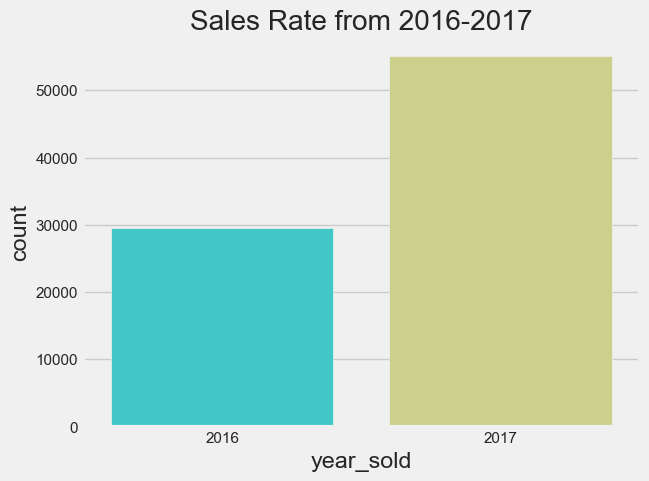

In [392]:
sns.countplot(x='year_sold', data=df, palette='rainbow')
plt.title('Sales Rate from 2016-2017')

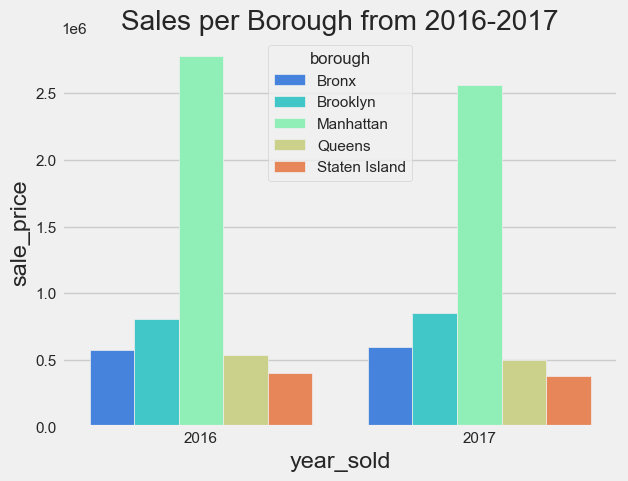

In [393]:
summary_data = df.groupby(['year_sold', 'borough'])['sale_price'].mean().reset_index()

# Barplot'u oluşturun
sns.barplot(
    x='year_sold', 
    y='sale_price', 
    hue='borough', 
    data=summary_data, 
    palette='rainbow', 
    ci=None
)
plt.title('Sales per Borough from 2016-2017')
plt.show()

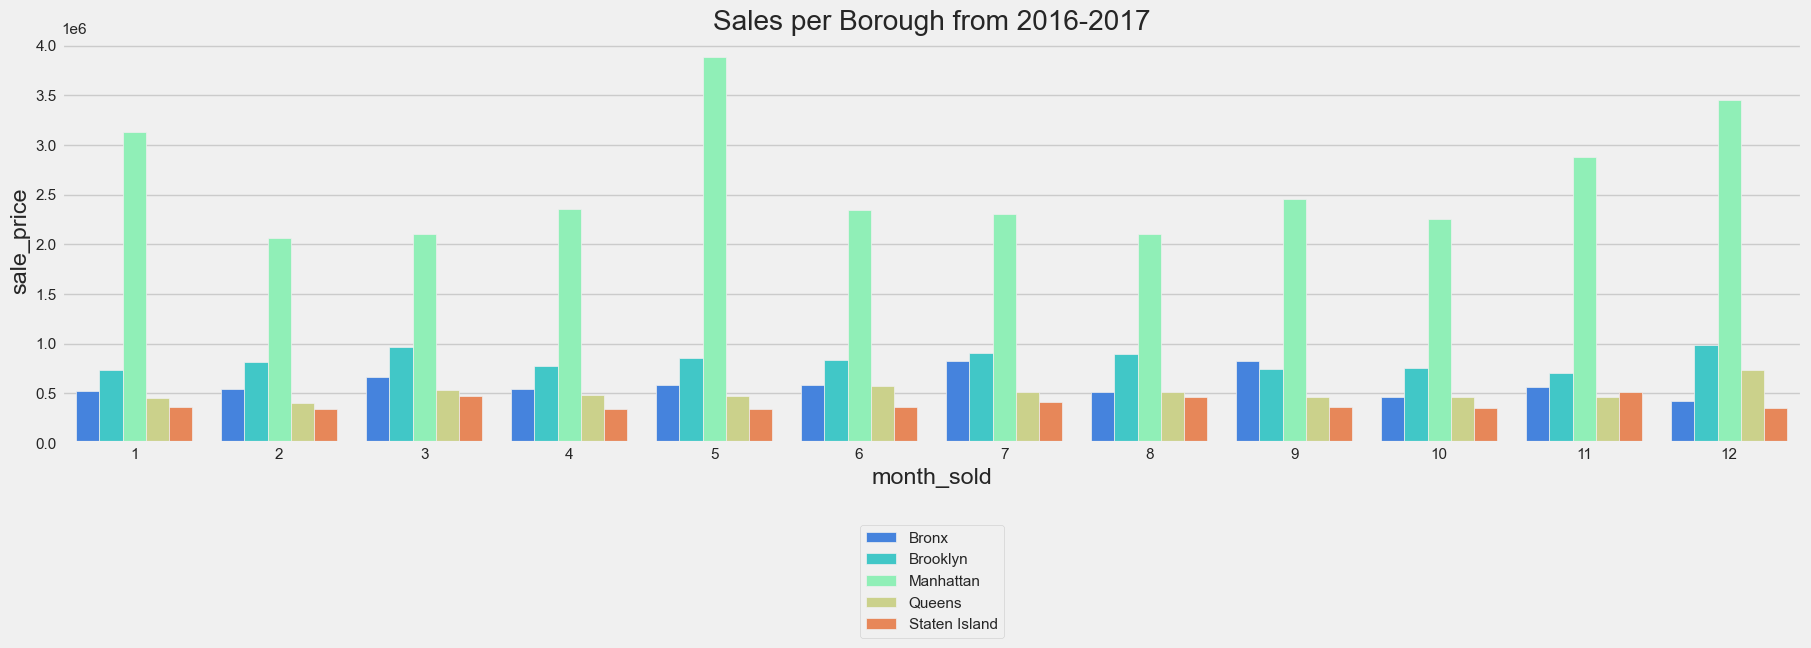

In [394]:
summary_data = df.groupby(['month_sold', 'borough'])['sale_price'].mean().reset_index()

plt.figure(figsize=(20,5))
sns.barplot(
    x='month_sold', 
    y='sale_price', 
    hue='borough', 
    data=summary_data, 
    palette='rainbow', 
    ci=None
)
plt.title('Sales per Borough from 2016-2017')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
plt.show()

'\nIt is noticed that though the number of sales increased from the year 2016 to 2017, \nthe sales prices per Borough(location) remained in the same ranges\nAlso, the property prices are much higher at Manhattan than at any other location.\nAs per months, property sales for 2017 took place from January till August, \nand for 2016 from September till December.'

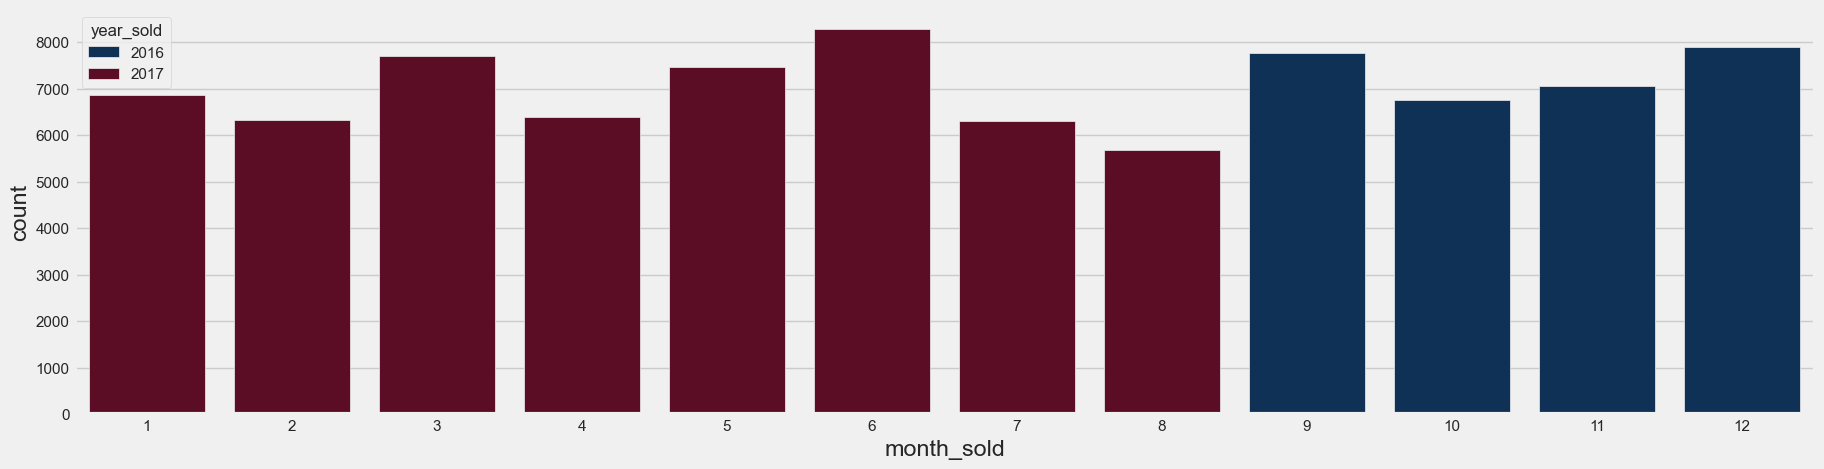

In [395]:
plt.figure(figsize=(20,5))
sns.countplot(x='month_sold', hue='year_sold', data=df, palette='RdBu_r')

"""
It is noticed that though the number of sales increased from the year 2016 to 2017, 
the sales prices per Borough(location) remained in the same ranges
Also, the property prices are much higher at Manhattan than at any other location.
As per months, property sales for 2017 took place from January till August, 
and for 2016 from September till December."""

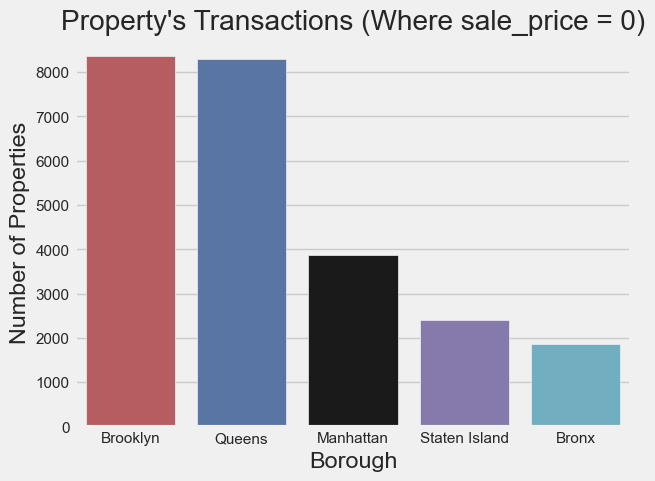

In [396]:
df_filtered = df[df['sale_price'] == 0]

# Create the bar plot with Seaborn
sns.countplot(
    x="borough",
    data=df_filtered,
    order=df_filtered['borough'].value_counts().index,  # Sort by value counts
    palette=['r', 'b', 'k', 'm', 'c']  # Set colors
)

# Customize the plot
plt.title("Property's Transactions (Where sale_price = 0)")
plt.xlabel("Borough")
plt.ylabel("Number of Properties")
plt.show()

Since 0 sales means that it's a property transaction so this graph shows the amount of property transactions in each borough.

Text(0.5, 1.0, 'average sales price per propertys usage of buildings')

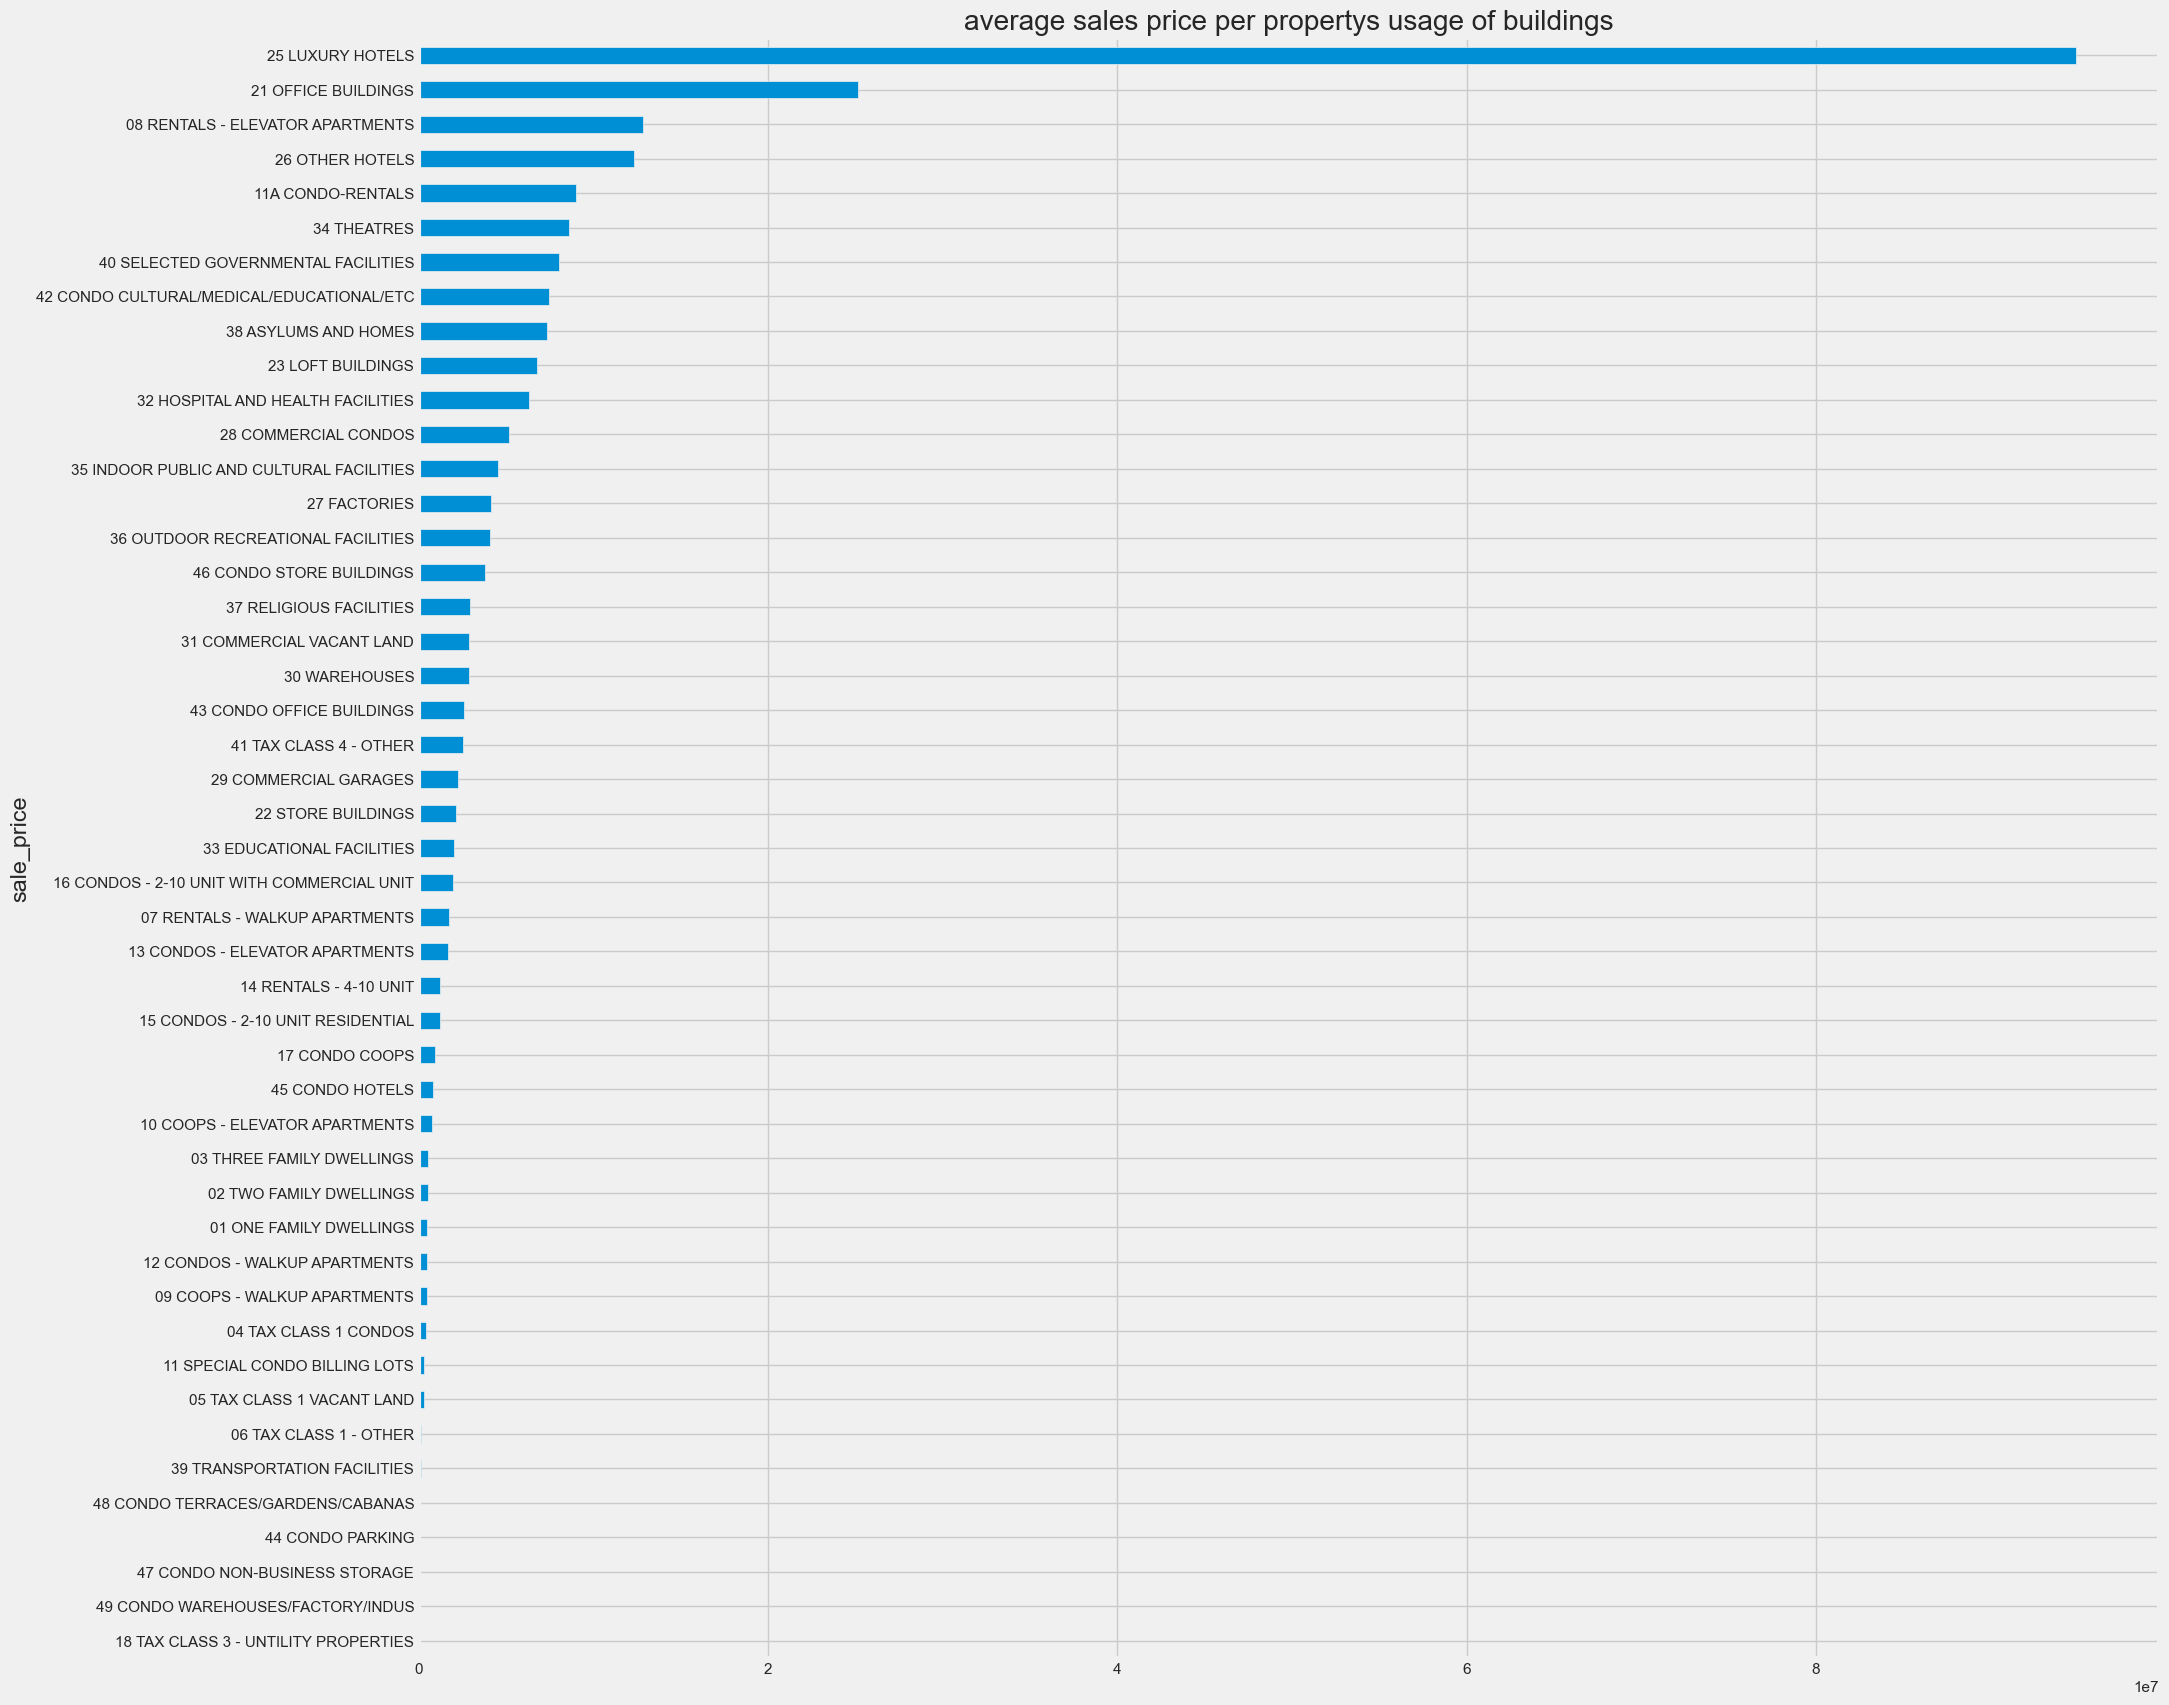

In [397]:
plt.figure(figsize=(20,20))

df['sale_price'].groupby(df['building_class_category']).mean().sort_values().plot.barh()
plt.ylabel("sale_price")

plt.title('average sales price per propertys usage of buildings')

Seems to Luxury hotels and office buildings is represents the largest average price category in sales and Untility properties, Warehouses/Factory/Indus are the lowest average price building category in sales.

Text(0.5, 0, 'sale_price')

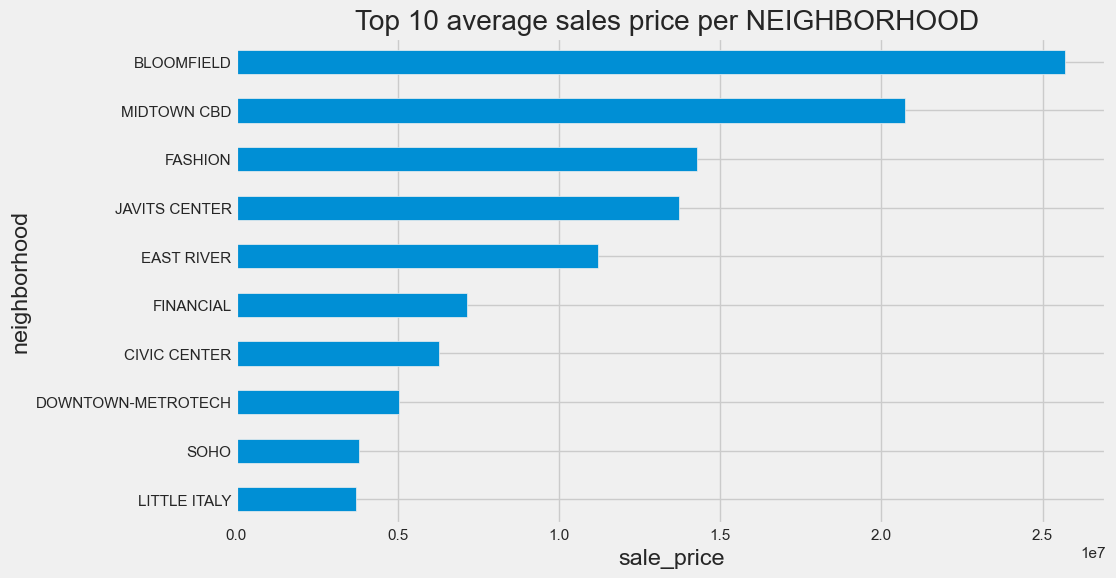

In [398]:
plt.figure(figsize=(10,6))
df['sale_price'].groupby(df['neighborhood']).mean().sort_values()[244:254].plot.barh()
plt.title('Top 10 average sales price per NEIGHBORHOOD ')
plt.xlabel("sale_price")

BloomField and Midtown CBD have the largest average sales between all neighborhood.

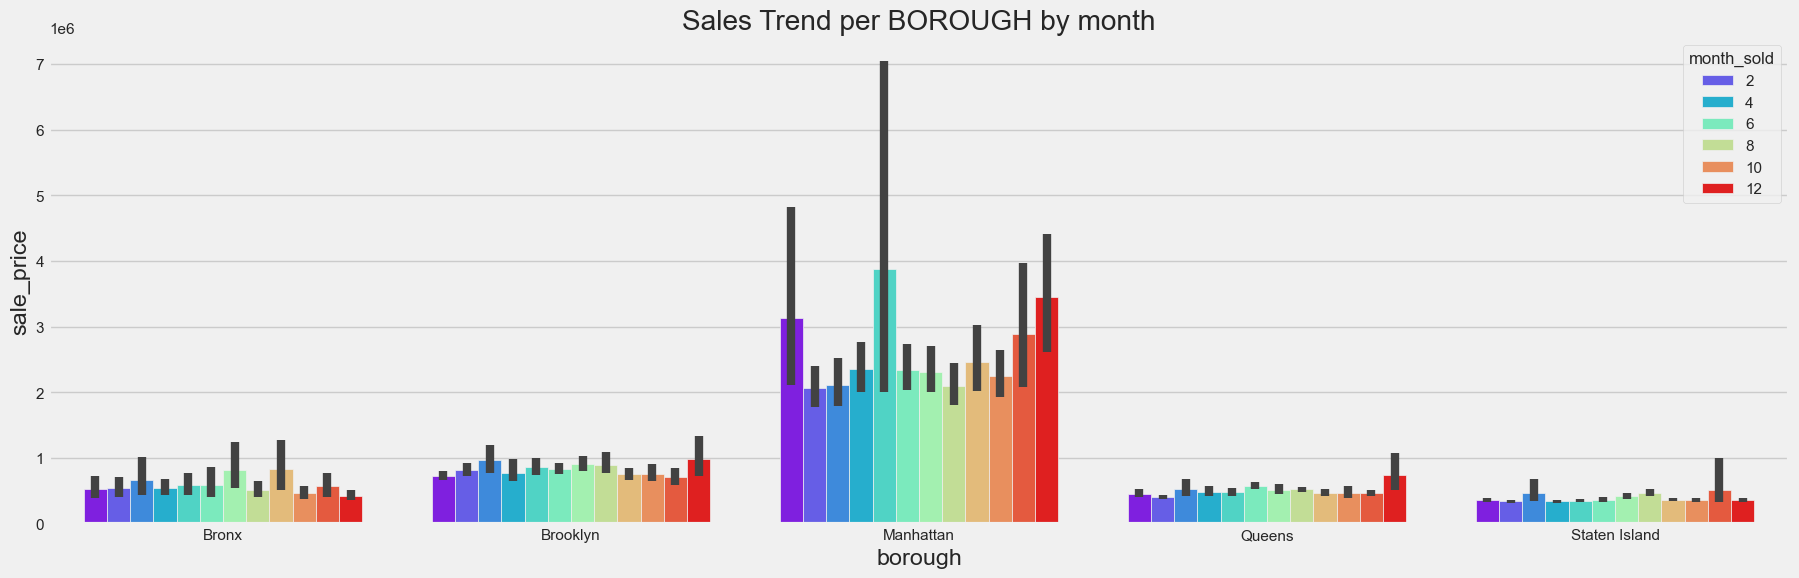

In [399]:
indexed_df = df.reset_index(drop=True)

plt.figure(figsize=(20,6))
sns.barplot(x='borough', y='sale_price', hue='month_sold', data=indexed_df, palette='rainbow')
plt.title('Sales Trend per BOROUGH by month')
plt.ylabel('sale_price')
plt.show()

In [400]:
#m = df.select_dtypes(np.number)
#df[m.columns]= m.round().astype('Int64')
pd.options.display.float_format = '{:,.0f}'.format
# Filter DataFrame
df2 = df[(df['sale_price'] > 100000) & (df['sale_price'] < 5000000)]
df2.rename(columns = {"sale_price":"sale_price"},inplace = True)

boroughs = ['Manhattan', 'Bronx', 'Brooklyn', 'Queens', 'Staten Island']
colors = ['rgb(12, 12, 140)', 'rgb(8,81,156)', 'rgb(12, 12, 140)', 'rgb(12, 128, 128)', 'rgb(12, 12, 140)']

traces = []
for borough, color in zip(boroughs, colors):
    trace = go.Box(
        y=df2[df2.borough == borough].sale_price,
        name=borough,
        marker=dict(color=color)
    )
    traces.append(trace)

layout = go.Layout(
    title='Housing Prices by Boroughs',
    xaxis=dict(title='Borough'),
    yaxis=dict(title='sale_price'),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)'
)

fig = go.Figure(data=traces, layout=layout)
py.iplot(fig)

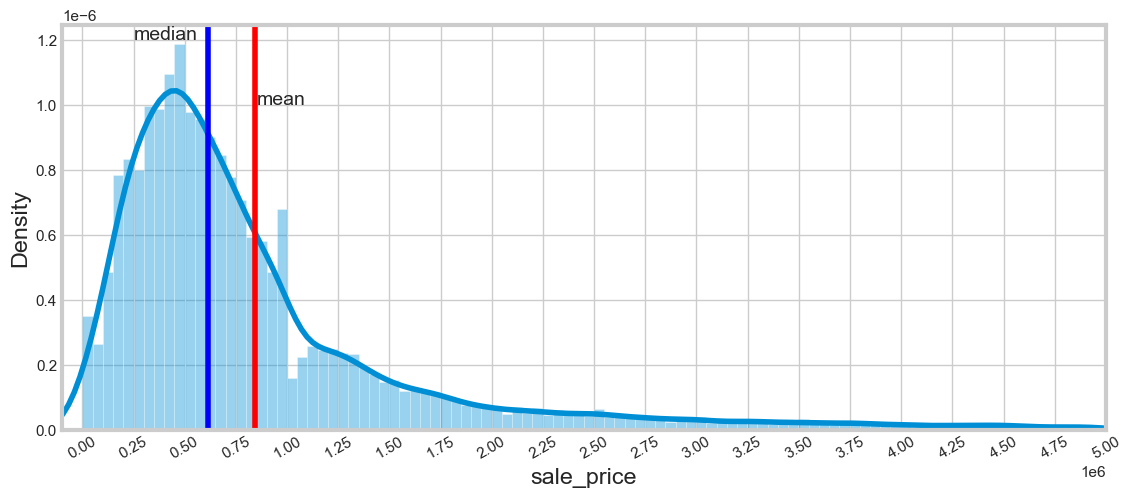

In [401]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,5))
plotd = sns.distplot(df[(df['sale_price']>100) & (df['sale_price'] < 5000000)]['sale_price'], kde=True, bins=100)

tick_spacing=250000
plotd.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plotd.set_xlim([-100000, 5000000])
plt.xticks(rotation=30)
plt.axvline(df[(df['sale_price']>100) & (df['sale_price'] < 5000000)]['sale_price'].mean(), c='red')
plt.axvline(df[(df['sale_price']>100) & (df['sale_price'] < 5000000)]['sale_price'].median(), c='blue')
plt.text(250000,0.0000012, "median")
plt.text(850000,0.0000010, "mean")
plt.show()

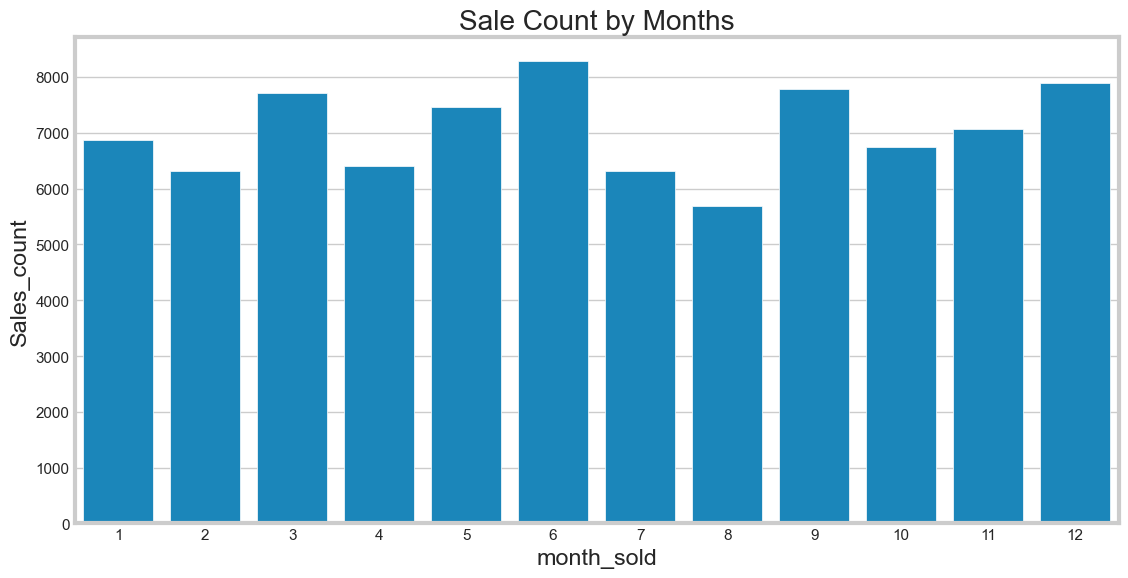

In [402]:
df_bar=df[['month_sold', 'sale_price']].groupby(by='month_sold').count().sort_values(by='month_sold', ascending=True).reset_index()
df_bar.columns.values[1]='Sales_count'

plt.figure(figsize=(12,6))
sns.barplot(y = 'Sales_count', x = 'month_sold', data = df_bar)
plt.title('Sale Count by Months')
plt.show()

Text(0.5, 1.0, 'sale_prices by commercial_units')

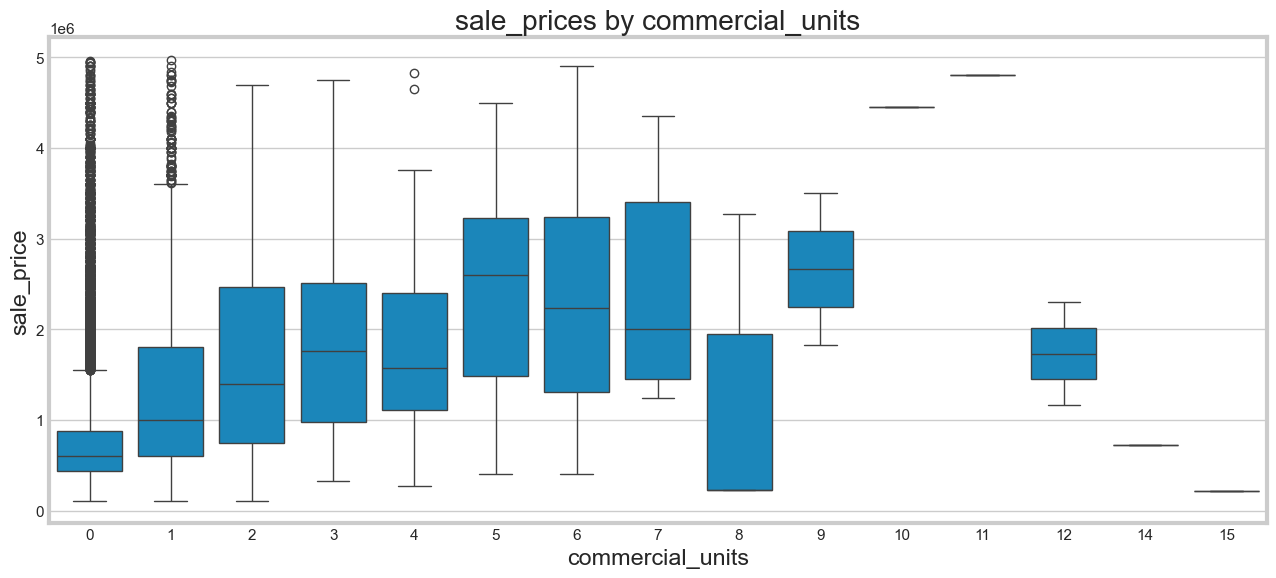

In [403]:
dataset = df[
    (df['commercial_units']<20) & (df['total_units']<50) & 
    (df['sale_price']<5000000) & (df['sale_price']>100000) & 
    (df['gross_square_feet']>0)
    ]

plt.figure(figsize=(14,6))
sns.boxplot(x='commercial_units', y="sale_price", data=dataset)
plt.title('sale_prices by commercial_units')

In [404]:
segment_df = df.copy()
segment_df = segment_df[segment_df['sale_price']>0]
ten_segments = np.linspace(0.1,0.9,9).tolist()
segment_borders = segment_df['sale_price'].quantile(ten_segments).tolist()
segment_borders = [0] + segment_borders + [float('inf')]
segment_borders

[0,
 195000.0,
 317500.0,
 420000.0,
 515000.0,
 625500.0,
 751151.9999999992,
 934630.9999999995,
 1290000.0,
 2250000.0,
 inf]

In [405]:
segment_names = ['Segment_' + str(number) for number in list(range(1,11))]
segment_names

['Segment_1',
 'Segment_2',
 'Segment_3',
 'Segment_4',
 'Segment_5',
 'Segment_6',
 'Segment_7',
 'Segment_8',
 'Segment_9',
 'Segment_10']

In [406]:
segment_df.insert(9, 'segmented_sale_price', 
                pd.cut(segment_df['sale_price'], bins = segment_borders, labels=segment_names))

segment_borders_df = pd.DataFrame(np.array([segment_borders[:-1], segment_borders[1:]]).T, index=segment_names, 
                          columns=["From", 'Up to'])
segment_borders_df

,From,Up to
Segment_1,0,"195,000"
Segment_2,"195,000","317,500"
Segment_3,"317,500","420,000"
Segment_4,"420,000","515,000"
Segment_5,"515,000","625,500"
Segment_6,"625,500","751,152"
Segment_7,"751,152","934,631"
Segment_8,"934,631","1,290,000"
Segment_9,"1,290,000","2,250,000"
Segment_10,"2,250,000",inf


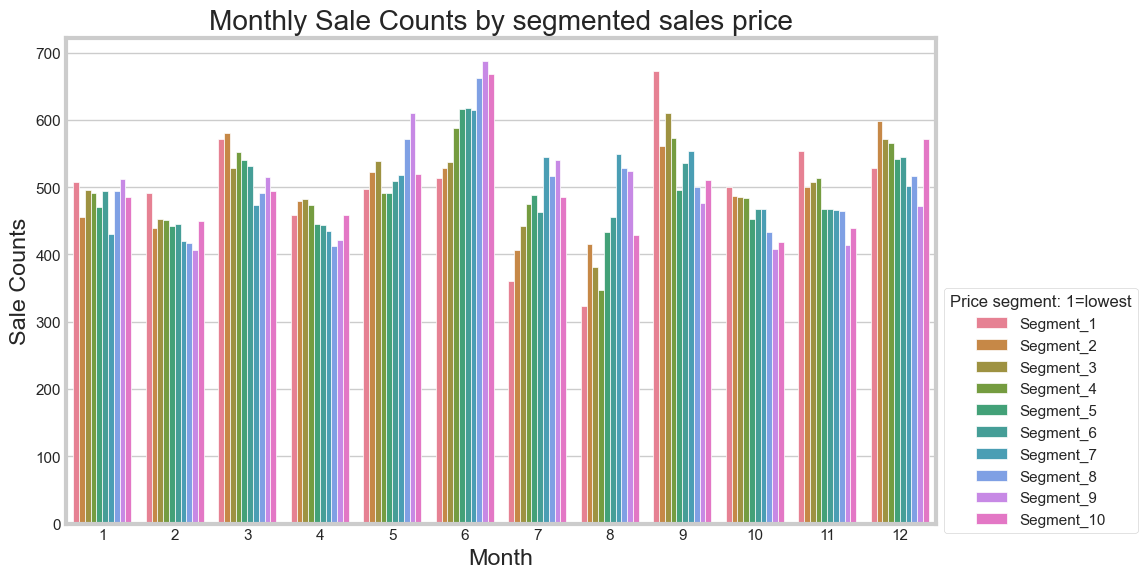

In [407]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=segment_df, x="month_sold", hue='segmented_sale_price')
ax.legend(title="Price segment: 1=lowest", bbox_to_anchor=(1, 0.5), loc=2)

plt.title('Monthly Sale Counts by segmented sales price')
plt.xlabel('Month')
plt.ylabel('Sale Counts')

plt.show()

<a id='3'></a><center> <h2 style="background-color:green; color:white" ><br>3. DATA PREPROCESSING  <br></h2>

In [408]:
b_class_cut = df['building_class_at_time_of_sale'].nunique() * 0.025
print("b_class_cut: ", b_class_cut)
b_class_cut_list = df['building_class_at_time_of_sale'
         ].value_counts().loc[lambda x : x < b_class_cut].index.to_list()

df['building_class_at_time_of_sale'].replace(b_class_cut_list, 'other_class_time_of_sale_categories', inplace=True)


b_class_cat_cut = df['building_class_category'].nunique() * 0.025
print("b_class_cat_cut: ", b_class_cat_cut)
b_class_cat_cut_list = df['building_class_category'
         ].value_counts().loc[lambda x : x < b_class_cat_cut].index.to_list()
df['building_class_category'].replace(b_class_cat_cut_list, 'other_class_categories', inplace=True)


neighb_cut = df['neighborhood'].nunique() * 0.01
neighb_cut
print("neighb_cut: ", neighb_cut)
neighb_cut_list = df['neighborhood'
         ].value_counts().loc[lambda x : x < neighb_cut].index.to_list()
df['neighborhood'].replace(neighb_cut_list, 'other_neighborhoods', inplace=True)


df["tax_class_at_present"] = df["tax_class_at_present"].map({'1': 1,'1A':1, '1B':1, '1C':1, 
                                                             '2':2, '2C':2, '2B':2, '2A':2,
                                                             '4':4})

dummy_categorical  = ["borough","neighborhood","building_class_at_time_of_sale","building_class_category","tax_class_at_present", "building_class_category"]

b_class_cut:  4.15
b_class_cat_cut:  1.175
neighb_cut:  2.54


In [409]:
df.head()

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,building_class_at_present,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_date,month_sold,year_sold,age,age_category
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,392,6,C2,10009,5,0,5,"1,633",6440,1900,2,C2,"6,625,000",2017-07-19,7,2017,121,Pre-War
5,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,C7,10009,28,3,31,"4,616",18690,1900,2,C7,0,2016-12-14,12,2016,121,Pre-War
6,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,C7,10009,16,1,17,"2,212",7803,1900,2,C7,0,2016-12-09,12,2016,121,Pre-War
7,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,402,21,C4,10009,10,0,10,"2,272",6794,1913,2,C4,"3,936,272",2016-09-23,9,2016,108,Pre-War
8,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,404,55,C2,10009,6,0,6,"2,369",4615,1900,2,C2,"8,000,000",2016-11-17,11,2016,121,Pre-War


In [410]:
#check dataframe where year_built is 0 years
print(df[df['year_built']==0].head())
#remove rows where year_built = 0
df = df[df['year_built']!=0]

      borough   neighborhood          building_class_category  \
78  Manhattan  ALPHABET CITY                11A CONDO-RENTALS   
80  Manhattan  ALPHABET CITY    12 CONDOS - WALKUP APARTMENTS   
81  Manhattan  ALPHABET CITY    12 CONDOS - WALKUP APARTMENTS   
82  Manhattan  ALPHABET CITY    12 CONDOS - WALKUP APARTMENTS   
91  Manhattan  ALPHABET CITY  13 CONDOS - ELEVATOR APARTMENTS   

    tax_class_at_present block   lot building_class_at_present zip_code  \
78                   NaN   394  1602                       NaN        0   
80                     2   386  1002                        R2    10009   
81                     2   398  1039                        R2    10009   
82                     2   405  1211                        R2    10009   
91                     2   375  1004                        R4    10009   

    residential_units  commercial_units  total_units  land_square_feet  \
78                  0                 0            0               NaN   
80        

In [411]:
# Remove outliers of zero gross square feet and land square feet.
df = df[df['land_square_feet']!=0]
df = df[df['gross_square_feet']!=0]

In [412]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format)).transpose()

,count,mean,min,25%,50%,75%,max,std
tax_class_at_present,45492.00000,1.27247,1.00000,1.00000,1.00000,1.00000,4.00000,0.73635
residential_units,45492.00000,3.32188,0.00000,1.00000,2.00000,2.00000,1844.00000,22.28129
commercial_units,45492.00000,0.33547,0.00000,0.00000,0.00000,0.00000,2261.00000,11.54183
total_units,45492.00000,3.65623,0.00000,1.00000,2.00000,2.00000,2261.00000,25.24460
land_square_feet,45487.00000,4354.20863,200.00000,2000.00000,2500.00000,4000.00000,4228300.00000,38713.83133
gross_square_feet,45492.00000,5046.53528,60.00000,1416.00000,2000.00000,2880.00000,3750565.00000,39107.28354
year_built,45492.00000,1940.20927,1680.00000,1920.00000,1930.00000,1955.00000,2017.00000,30.13607
sale_price,45492.00000,1058429.22109,0.00000,0.00000,400000.00000,735000.00000,2210000000.00000,13671769.38435
sale_date,45492.00000,.5f,.5f,.5f,.5f,.5f,.5f,nan
month_sold,45492.00000,6.56865,1.00000,3.00000,6.00000,10.00000,12.00000,3.50074


<Axes: xlabel='age', ylabel='sale_price'>

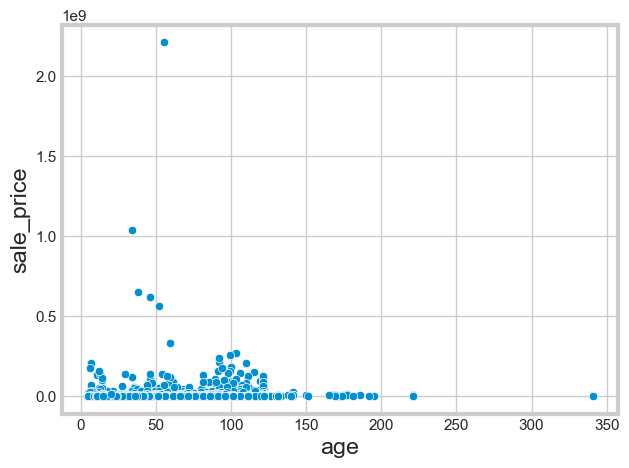

In [413]:
#simple scatter plot to find potential outliers
sns.scatterplot(data=df, x="age", y="sale_price")

In [414]:
#remove outlier prices
df = df[df['sale_price'] <500000000] 

<Axes: xlabel='age', ylabel='sale_price'>

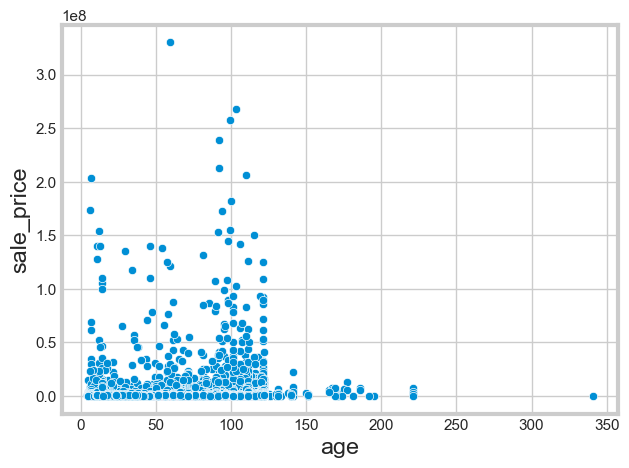

In [415]:
sns.scatterplot(data=df, x="age", y="sale_price")

In [416]:
df_afterprocessing = df.copy()

In [417]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45487 entries, 4 to 8413
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   borough                         45487 non-null  category      
 1   neighborhood                    45487 non-null  category      
 2   building_class_category         45487 non-null  category      
 3   tax_class_at_present            45487 non-null  float64       
 4   block                           45487 non-null  category      
 5   lot                             45487 non-null  category      
 6   building_class_at_present       45487 non-null  category      
 7   zip_code                        45487 non-null  category      
 8   residential_units               45487 non-null  int64         
 9   commercial_units                45487 non-null  int64         
 10  total_units                     45487 non-null  int64         
 11  land_squ

In [418]:
#df = df[(df['sale_price'] < 50000000) & (df['sale_price'] > 1000) & 
#        (df['residential_units'] < 800) & (df['commercial_units'] < 800) & 
#        (df['land_square_feet'] < df['gross_square_feet']) & 
#        (df['gross_square_feet'] < 12530) & (df['gross_square_feet'] > 0)]

df = df[(df['sale_price'] < 50000000) & (df['sale_price'] > 1000)]


df = df.drop_duplicates()

In [419]:
df.head()

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,building_class_at_present,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_date,month_sold,year_sold,age,age_category
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,392,6,C2,10009,5,0,5,"1,633",6440,1900,2,C2,"6,625,000",2017-07-19,7,2017,121,Pre-War
7,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,402,21,C4,10009,10,0,10,"2,272",6794,1913,2,C4,"3,936,272",2016-09-23,9,2016,108,Pre-War
8,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,404,55,C2,10009,6,0,6,"2,369",4615,1900,2,C2,"8,000,000",2016-11-17,11,2016,121,Pre-War
10,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,406,32,C4,10009,8,0,8,"1,750",4226,1920,2,C4,"3,192,840",2016-09-23,9,2016,101,Pre-War
13,Manhattan,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,D9,10009,24,0,24,"4,489",18523,1920,2,D9,"16,232,000",2016-11-07,11,2016,101,Pre-War


In [420]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28290 entries, 4 to 8413
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   borough                         28290 non-null  category      
 1   neighborhood                    28290 non-null  category      
 2   building_class_category         28290 non-null  category      
 3   tax_class_at_present            28290 non-null  float64       
 4   block                           28290 non-null  category      
 5   lot                             28290 non-null  category      
 6   building_class_at_present       28290 non-null  category      
 7   zip_code                        28290 non-null  category      
 8   residential_units               28290 non-null  int64         
 9   commercial_units                28290 non-null  int64         
 10  total_units                     28290 non-null  int64         
 11  land_squ

In [421]:
def get_categorical_and_numeric_columns(dataframe, number_of_unique_classes):
    categorical_columns = [col for col in dataframe.columns if len(dataframe[col].unique()) <= number_of_unique_classes
                          or dataframe[col].dtype == "category"]
    
    new_categorical_columns = []
    for cat_cols in categorical_columns:
        new_categorical_columns.append(cat_cols)
        
    numeric_columns = [col for col in dataframe.columns if len(dataframe[col].unique()) > number_of_unique_classes
                       and dataframe[col].dtype != "category" or col not in new_categorical_columns]
    numeric_columns.remove(cons.target_variable)  
    return new_categorical_columns, numeric_columns

def unique_value_analysis(dataframe, number_of_unique_classes):
    check_flag = 0
    for i in range(0, len(number_of_unique_classes)):
        cat_cols, num_cols = get_categorical_and_numeric_columns(dataframe, number_of_unique_classes[i])
        print('Number of Unique Value:',number_of_unique_classes[i],' Number of Categorical Value:',len(cat_cols),' Number of Numerical Value: ', len(num_cols))
        if check_flag < len(cat_cols)*1.1 and check_flag > 0:
            return number_of_unique_classes[i]
        else:
            check_flag = len(cat_cols)

In [422]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28290 entries, 4 to 8413
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   borough                         28290 non-null  category      
 1   neighborhood                    28290 non-null  category      
 2   building_class_category         28290 non-null  category      
 3   tax_class_at_present            28290 non-null  float64       
 4   block                           28290 non-null  category      
 5   lot                             28290 non-null  category      
 6   building_class_at_present       28290 non-null  category      
 7   zip_code                        28290 non-null  category      
 8   residential_units               28290 non-null  int64         
 9   commercial_units                28290 non-null  int64         
 10  total_units                     28290 non-null  int64         
 11  land_squ

In [423]:
threshold_value = unique_value_analysis(df,[2, 3, 5, 10, 20, 50])
print("threshold_value: ", threshold_value)
cat_cols, num_cols = get_categorical_and_numeric_columns(df, threshold_value)

Number of Unique Value: 2  Number of Categorical Value: 11  Number of Numerical Value:  10
Number of Unique Value: 3  Number of Categorical Value: 12  Number of Numerical Value:  9
threshold_value:  3


In [424]:
df[cat_cols].head()

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,building_class_at_present,zip_code,tax_class_at_time_of_sale,building_class_at_time_of_sale,year_sold,age_category
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,392,6,C2,10009,2,C2,2017,Pre-War
7,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,402,21,C4,10009,2,C4,2016,Pre-War
8,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,404,55,C2,10009,2,C2,2016,Pre-War
10,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,406,32,C4,10009,2,C4,2016,Pre-War
13,Manhattan,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,D9,10009,2,D9,2016,Pre-War


In [425]:
df[num_cols].head()

,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_date,month_sold,age
4,5,0,5,"1,633",6440,1900,2017-07-19,7,121
7,10,0,10,"2,272",6794,1913,2016-09-23,9,108
8,6,0,6,"2,369",4615,1900,2016-11-17,11,121
10,8,0,8,"1,750",4226,1920,2016-09-23,9,101
13,24,0,24,"4,489",18523,1920,2016-11-07,11,101


Text(0.5, 1.0, 'Variable Correlation')

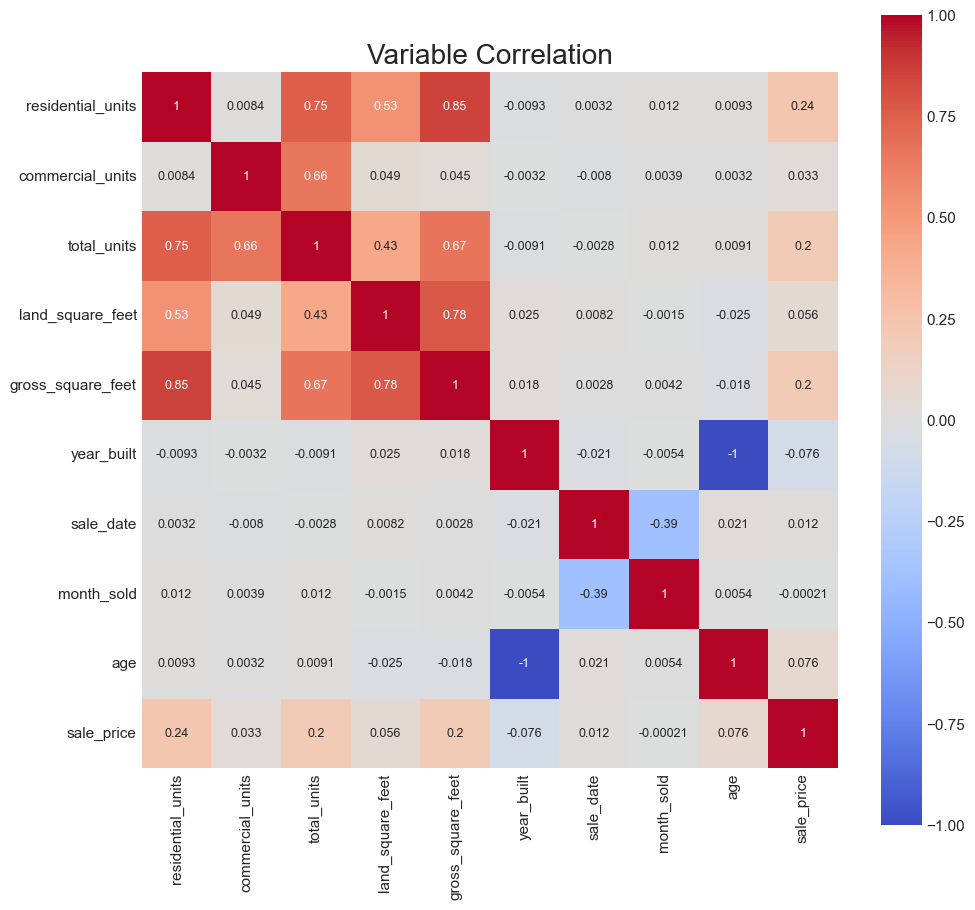

In [426]:
#correlation matrix
corrmat = df[num_cols+[cons.target_variable]].corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, cmap = 'coolwarm', square=True, annot= True, annot_kws={"size": 9})
plt.title('Variable Correlation')

In [427]:
## Statistical Test

# H0: The earlier bult date of the house result in the lower house price 
# H1: The earlier built date of the house not result in the lower house price

import scipy.stats as stats

X = df['year_built'].array
Y = df['sale_price'].array
result = stats.pearsonr(X,Y)
print(result)

PearsonRResult(statistic=-0.07617519789932409, pvalue=1.1069674245291915e-37)


As the p-value is shown from the Pearson Correlation test, the p-value is way less than significance level of 0.05. 
Therefore, we shall reject null hypothesis based on the p-value output from Pearson test

In [428]:
#################### FILLING MISSING VALUES #########################

In [429]:
#### MISSING DATA ANALYSIS

df.replace(' ',np.nan, inplace=True)
round(df.isna().sum() /len(df) *100,2)

borough                          0
neighborhood                     0
building_class_category          0
tax_class_at_present             0
block                            0
lot                              0
building_class_at_present        0
zip_code                         0
residential_units                0
commercial_units                 0
total_units                      0
land_square_feet                 0
gross_square_feet                0
year_built                       0
tax_class_at_time_of_sale        0
building_class_at_time_of_sale   0
sale_price                       0
sale_date                        0
month_sold                       0
year_sold                        0
age                              0
age_category                     0
dtype: float64

In [430]:
def missing_values_table(dataframe):
    variables_with_na = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[variables_with_na].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[variables_with_na].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    missing_df.reset_index(inplace=True)
    missing_df = missing_df.rename(columns = {'index':'Columns Name'})
    return missing_df
##################################################################################################################

def missing_vs_target(dataframe,target,variable_with_na):
    temp_df = dataframe.copy()
    for variable in variable_with_na:
        temp_df[variable + '_NA_FLAG'] = np.where(temp_df[variable].isnull(), 1, 0)    
    flags_na = temp_df.loc[:, temp_df.columns.str.contains('_NA_')].columns
    for variable in flags_na:
        print(pd.DataFrame({'TARGET_MEAN': temp_df.groupby(variable)[target].mean()}),end='\n\n\n')

missing_df = missing_values_table(df)
missing_df

,Columns Name,n_miss,ratio
0,land_square_feet,2,0


In [431]:
missing_drop_list = missing_df[missing_df['ratio']>40]['Columns Name'].values.tolist()
print(len(missing_drop_list), 'number of columns are removed.')
df.drop(missing_drop_list, axis=1, inplace=True)

0 number of columns are removed.


We see a huge correlation between RESIDENTIAL UNITS and TOTAL UNITS. Correlated features in general don't improve models so we will keep only one of these features.

In [432]:
df.drop(["residential_units"], axis = 1, inplace = True)
cat_cols, num_cols = get_categorical_and_numeric_columns(df, threshold_value)

In [433]:
df.head()

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,building_class_at_present,zip_code,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_date,month_sold,year_sold,age,age_category
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,392,6,C2,10009,0,5,"1,633",6440,1900,2,C2,"6,625,000",2017-07-19,7,2017,121,Pre-War
7,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,402,21,C4,10009,0,10,"2,272",6794,1913,2,C4,"3,936,272",2016-09-23,9,2016,108,Pre-War
8,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,404,55,C2,10009,0,6,"2,369",4615,1900,2,C2,"8,000,000",2016-11-17,11,2016,121,Pre-War
10,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,406,32,C4,10009,0,8,"1,750",4226,1920,2,C4,"3,192,840",2016-09-23,9,2016,101,Pre-War
13,Manhattan,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,D9,10009,0,24,"4,489",18523,1920,2,D9,"16,232,000",2016-11-07,11,2016,101,Pre-War


In [434]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28290 entries, 4 to 8413
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   borough                         28290 non-null  category      
 1   neighborhood                    28290 non-null  category      
 2   building_class_category         28290 non-null  category      
 3   tax_class_at_present            28290 non-null  float64       
 4   block                           28290 non-null  category      
 5   lot                             28290 non-null  category      
 6   building_class_at_present       28290 non-null  category      
 7   zip_code                        28290 non-null  category      
 8   commercial_units                28290 non-null  int64         
 9   total_units                     28290 non-null  int64         
 10  land_square_feet                28288 non-null  float64       
 11  gross_sq

In [435]:
# Imputing missing values in 'LAND SQUARE FEET' and 'GROSS SQUARE FEET' using the median
for col in ['land_square_feet', 'gross_square_feet']:
    print(col)
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)

# Removing rows where 'SALE PRICE' is missing
# Deleting 0 price transfer transactions
# Deleting nan values of dependence variable

df = df[df["sale_price"] > 0]
df = df[df["sale_price"].notnull()]


df.info()

land_square_feet
gross_square_feet
<class 'pandas.core.frame.DataFrame'>
Index: 28290 entries, 4 to 8413
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   borough                         28290 non-null  category      
 1   neighborhood                    28290 non-null  category      
 2   building_class_category         28290 non-null  category      
 3   tax_class_at_present            28290 non-null  float64       
 4   block                           28290 non-null  category      
 5   lot                             28290 non-null  category      
 6   building_class_at_present       28290 non-null  category      
 7   zip_code                        28290 non-null  category      
 8   commercial_units                28290 non-null  int64         
 9   total_units                     28290 non-null  int64         
 10  land_square_feet                28290 non

In [436]:
# Square feet should not be 0.
#df = df[df["LAND SQUARE FEET"] != 0]
#df = df[df["GROSS SQUARE FEET"] != 0]
#df = df.dropna() 

df.drop_duplicates(keep = "last", inplace=True)

In [437]:
df_after_missing = df.copy()

In [438]:
# Removing data where commercial + residential doesn't equal total units
#df = df[df['TOTAL UNITS'] == df['commercial_units'] + df['RESIDENTIAL UNITS']]
#df[["TOTAL UNITS", "sale_price"]].groupby(['TOTAL UNITS'], as_index=False).count().sort_values(by='sale_price', ascending=False).tail(10)

In [439]:
################ OUTLIER ANALYSIS

In [440]:
cat_cols, num_cols = get_categorical_and_numeric_columns(df, threshold_value)

In [441]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28290 entries, 4 to 8413
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   borough                         28290 non-null  category      
 1   neighborhood                    28290 non-null  category      
 2   building_class_category         28290 non-null  category      
 3   tax_class_at_present            28290 non-null  float64       
 4   block                           28290 non-null  category      
 5   lot                             28290 non-null  category      
 6   building_class_at_present       28290 non-null  category      
 7   zip_code                        28290 non-null  category      
 8   commercial_units                28290 non-null  int64         
 9   total_units                     28290 non-null  int64         
 10  land_square_feet                28290 non-null  float64       
 11  gross_sq

In [442]:
df[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 28290 entries, 4 to 8413
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   commercial_units   28290 non-null  int64         
 1   total_units        28290 non-null  int64         
 2   land_square_feet   28290 non-null  float64       
 3   gross_square_feet  28290 non-null  int32         
 4   year_built         28290 non-null  int64         
 5   sale_date          28290 non-null  datetime64[ns]
 6   month_sold         28290 non-null  int64         
 7   age                28290 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(5)
memory usage: 1.8 MB


In [443]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
##################################################################################################################

def replace_with_thresholds(dataframe, columns_list):
    for variable in columns_list:
        print(variable)
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        if low_limit < 0:
            low_limit = 0
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
##################################################################################################################

def remove_outliers(dataframe, numeric_columns):
    for variable in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe_without_outliers = dataframe[~((dataframe[variable] < low_limit) | (dataframe[variable] > up_limit))]
    return dataframe_without_outliers
##################################################################################################################

def has_outliers(dataframe, num_col_names, plot=False):
    variable_names = []
    dataframe = dataframe[num_col_names]
    for col in num_col_names:
        low_limit, up_limit = outlier_thresholds(dataframe, col)
        if dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].any(axis=None):
            number_of_outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].shape[0]
            print(col, ":", number_of_outliers)
            variable_names.append(col)
            if plot:
                sns.boxplot(x=dataframe[col])
                plt.show()
    return variable_names

In [444]:
outlier_variable_names = has_outliers(df, num_cols)

commercial_units : 2528
total_units : 2499
land_square_feet : 1442
gross_square_feet : 2189
year_built : 19
age : 19


In [445]:
df.head()

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,building_class_at_present,zip_code,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_date,month_sold,year_sold,age,age_category
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,392,6,C2,10009,0,5,"1,633",6440,1900,2,C2,"6,625,000",2017-07-19,7,2017,121,Pre-War
7,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,402,21,C4,10009,0,10,"2,272",6794,1913,2,C4,"3,936,272",2016-09-23,9,2016,108,Pre-War
8,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,404,55,C2,10009,0,6,"2,369",4615,1900,2,C2,"8,000,000",2016-11-17,11,2016,121,Pre-War
10,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,406,32,C4,10009,0,8,"1,750",4226,1920,2,C4,"3,192,840",2016-09-23,9,2016,101,Pre-War
13,Manhattan,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,D9,10009,0,24,"4,489",18523,1920,2,D9,"16,232,000",2016-11-07,11,2016,101,Pre-War


In [446]:
replace_with_thresholds(df, outlier_variable_names)

commercial_units
total_units
land_square_feet
gross_square_feet
year_built
age


In [447]:
df.head()

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,building_class_at_present,zip_code,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_date,month_sold,year_sold,age,age_category
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,392,6,C2,10009,0,4,"1,633",4575,"1,900",2,C2,"6,625,000",2017-07-19,7,2017,121,Pre-War
7,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,402,21,C4,10009,0,4,"2,272",4575,"1,913",2,C4,"3,936,272",2016-09-23,9,2016,108,Pre-War
8,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,404,55,C2,10009,0,4,"2,369",4575,"1,900",2,C2,"8,000,000",2016-11-17,11,2016,121,Pre-War
10,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,406,32,C4,10009,0,4,"1,750",4226,"1,920",2,C4,"3,192,840",2016-09-23,9,2016,101,Pre-War
13,Manhattan,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,D9,10009,0,4,"4,489",4575,"1,920",2,D9,"16,232,000",2016-11-07,11,2016,101,Pre-War


In [448]:
# Deleting of unnecessary categorical variables for the model

del df["sale_date"]

In [449]:
cat_cols, num_cols = get_categorical_and_numeric_columns(df, threshold_value)

# Removing exceding skewness from features
for col in num_cols:
    if df[col].skew() > 1:
        df[col] = np.log1p(df[col])

In [450]:
round(df.describe([0.75,0.85,0.95,0.99,0.995,0.999]),3)

,tax_class_at_present,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_price,month_sold,year_sold,age
count,"28,290","28,290","28,290","28,290","28,290","28,290","28,290","28,290","28,290","28,290"
mean,1,0,2,8,8,"1,941","1,194,657",7,"2,017",80
std,1,0,1,0,0,30,"2,663,999",3,0,30
min,1,0,0,5,5,"1,862","1,162",1,"2,016",4
50%,1,0,2,8,8,"1,930","631,290",6,"2,017",91
75%,1,0,2,8,8,"1,959","965,000",10,"2,017",101
85%,1,0,3,8,8,"1,975","1,330,000",11,"2,017",111
95%,2,0,4,9,8,"2,004","3,400,000",12,"2,017",120
99%,4,0,4,9,8,"2,015","13,500,000",12,"2,017",122
99.5%,4,0,4,9,8,"2,016","20,000,000",12,"2,017",122


In [451]:
round(df.isna().sum() /len(df) *100,2)

borough                          0
neighborhood                     0
building_class_category          0
tax_class_at_present             0
block                            0
lot                              0
building_class_at_present        0
zip_code                         0
commercial_units                 0
total_units                      0
land_square_feet                 0
gross_square_feet                0
year_built                       0
tax_class_at_time_of_sale        0
building_class_at_time_of_sale   0
sale_price                       0
month_sold                       0
year_sold                        0
age                              0
age_category                     0
dtype: float64

In [452]:
df = df.dropna() 

In [453]:
df.head()

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,building_class_at_present,zip_code,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,month_sold,year_sold,age,age_category
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,392,6,C2,10009,0,4,7,8,"1,900",2,C2,"6,625,000",7,2017,121,Pre-War
7,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,402,21,C4,10009,0,4,8,8,"1,913",2,C4,"3,936,272",9,2016,108,Pre-War
8,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,404,55,C2,10009,0,4,8,8,"1,900",2,C2,"8,000,000",11,2016,121,Pre-War
10,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,406,32,C4,10009,0,4,7,8,"1,920",2,C4,"3,192,840",9,2016,101,Pre-War
13,Manhattan,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,D9,10009,0,4,8,8,"1,920",2,D9,"16,232,000",11,2016,101,Pre-War


In [454]:
#del df["residential_units"]
#del df["total_units"]
#del df["building_age"]
#del df["tax_class_at_present"]
#del df["building_class_at_time_of_sale"]

In [455]:
######################FEATURE SCALING

In [456]:
##################################################################################################################
def robust_scaler(variable):
    var_median = variable.median()
    quartile1 = variable.quantile(0.25)
    quartile3 = variable.quantile(0.75)
    interquantile_range = quartile3 - quartile1
    if int(interquantile_range) == 0:
        quartile1 = variable.quantile(0.05)
        quartile3 = variable.quantile(0.95)
        interquantile_range = quartile3 - quartile1
        if int(interquantile_range) == 0:
            quartile1 = variable.quantile(0.10)
            quartile3 = variable.quantile(0.99)
            interquantile_range = quartile3 - quartile1
            z = (variable - var_median) / interquantile_range
            return round(z, 3)
        z = (variable - var_median) / interquantile_range
        return round(z, 3)
    else:
        z = (variable - var_median) / interquantile_range
    return round(z, 3)
##################################################################################################################

In [457]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28290 entries, 4 to 8413
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   borough                         28290 non-null  category
 1   neighborhood                    28290 non-null  category
 2   building_class_category         28290 non-null  category
 3   tax_class_at_present            28290 non-null  float64 
 4   block                           28290 non-null  category
 5   lot                             28290 non-null  category
 6   building_class_at_present       28290 non-null  category
 7   zip_code                        28290 non-null  category
 8   commercial_units                28290 non-null  int64   
 9   total_units                     28290 non-null  float64 
 10  land_square_feet                28290 non-null  float64 
 11  gross_square_feet               28290 non-null  float64 
 12  year_built              

In [458]:
cat_cols, num_cols = get_categorical_and_numeric_columns(df, threshold_value)
for col in num_cols:
    df[col] = robust_scaler(df[col])
df.head()

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,building_class_at_present,zip_code,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,month_sold,year_sold,age,age_category
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,392,6,C2,10009,0,2,-0,1,-1,2,C2,"6,625,000",0,2017,1,Pre-War
7,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,402,21,C4,10009,0,2,-0,1,-0,2,C4,"3,936,272",0,2016,0,Pre-War
8,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,404,55,C2,10009,0,2,-0,1,-1,2,C2,"8,000,000",1,2016,1,Pre-War
10,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,406,32,C4,10009,0,2,-0,1,-0,2,C4,"3,192,840",0,2016,0,Pre-War
13,Manhattan,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,D9,10009,0,2,0,1,-0,2,D9,"16,232,000",1,2016,0,Pre-War


In [459]:
del df["lot"]
del df["block"]
del df["building_class_at_present"]
del df["zip_code"]
del df["year_sold"]
del df["neighborhood"]
del df["building_class_at_time_of_sale"]
del df["building_class_category"]

In [460]:
# Creating dummy variables from categorical variables
one_hot_variables  = ["borough", "tax_class_at_present", "tax_class_at_time_of_sale", "age_category"]
df = pd.get_dummies(df, columns=one_hot_variables, prefix_sep = "_" , drop_first = True)
#df.drop(one_hot_variables, axis = 1, inplace = True)

In [461]:
df.head()

,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_price,month_sold,age,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island,tax_class_at_present_2.0,tax_class_at_present_4.0,tax_class_at_time_of_sale_2,tax_class_at_time_of_sale_3,tax_class_at_time_of_sale_4,age_category_Pre-War
4,0,2,-0,1,-1,"6,625,000",0,1,False,True,False,False,True,False,True,False,False,True
7,0,2,-0,1,-0,"3,936,272",0,0,False,True,False,False,True,False,True,False,False,True
8,0,2,-0,1,-1,"8,000,000",1,1,False,True,False,False,True,False,True,False,False,True
10,0,2,-0,1,-0,"3,192,840",0,0,False,True,False,False,True,False,True,False,False,True
13,0,2,0,1,-0,"16,232,000",1,0,False,True,False,False,True,False,True,False,False,True


In [462]:
target_variable = "sale_price"

def df_split(df):    
    X = df.drop(target_variable, axis=1)
    y = df[target_variable].astype(int)
    X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 
    return X_train, X_test, y_train, y_test

In [463]:
X_train, X_test, y_train, y_test  = df_split(df)

model = LGBMRegressor().fit(X_train,y_train)
cv = KFold(n_splits=5, shuffle=True, random_state=0)
dataset = Dataset(df = df, target = target_variable, features = [col for col in df.columns if col != target_variable])
lofo_imp = LOFOImportance(dataset, cv=cv, model=model, scoring="r2", n_jobs=-1)
importance_df = lofo_imp.get_importance()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 787
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 15
[LightGBM] [Info] Start training from score 1204173.163883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 787
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 15
[LightGBM] [Info] Start training from score 1204173.163883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

  0%|          | 0/17 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1204173.163883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1182490.211382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

  6%|▌         | 1/17 [00:01<00:24,  1.55s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1204173.163883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1182490.211382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 12%|█▏        | 2/17 [00:03<00:25,  1.70s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1204173.163883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1182490.211382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 18%|█▊        | 3/17 [00:05<00:23,  1.71s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1204173.163883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1182490.211382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 24%|██▎       | 4/17 [00:06<00:21,  1.66s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 782
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1204173.163883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1182490.211382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 29%|██▉       | 5/17 [00:08<00:19,  1.65s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1204173.163883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1182490.211382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 35%|███▌      | 6/17 [00:09<00:17,  1.62s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1204173.163883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1182490.211382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 41%|████      | 7/17 [00:11<00:16,  1.68s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1204173.163883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1182490.211382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 47%|████▋     | 8/17 [00:13<00:15,  1.70s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 787
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 15
[LightGBM] [Info] Start training from score 1204173.163883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 788
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 15
[LightGBM] [Info] Start training from score 1182490.211382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 53%|█████▎    | 9/17 [00:14<00:13,  1.65s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1204173.163883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 533
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1182490.211382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 59%|█████▉    | 10/17 [00:16<00:11,  1.60s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1204173.163883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1182490.211382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 65%|██████▍   | 11/17 [00:18<00:10,  1.73s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1204173.163883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1182490.211382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 71%|███████   | 12/17 [00:20<00:08,  1.69s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 775
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1204173.163883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 776
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1182490.211382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 76%|███████▋  | 13/17 [00:21<00:06,  1.66s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1204173.163883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 533
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1182490.211382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 82%|████████▏ | 14/17 [00:23<00:04,  1.60s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1204173.163883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1182490.211382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 88%|████████▊ | 15/17 [00:24<00:03,  1.58s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1204173.163883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 14
[LightGBM] [Info] Start training from score 1182490.211382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 94%|█████████▍| 16/17 [00:26<00:01,  1.64s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 787
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 15
[LightGBM] [Info] Start training from score 1204173.163883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 788
[LightGBM] [Info] Number of data points in the train set: 22632, number of used features: 15
[LightGBM] [Info] Start training from score 1182490.211382
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

100%|██████████| 17/17 [00:28<00:00,  1.65s/it]


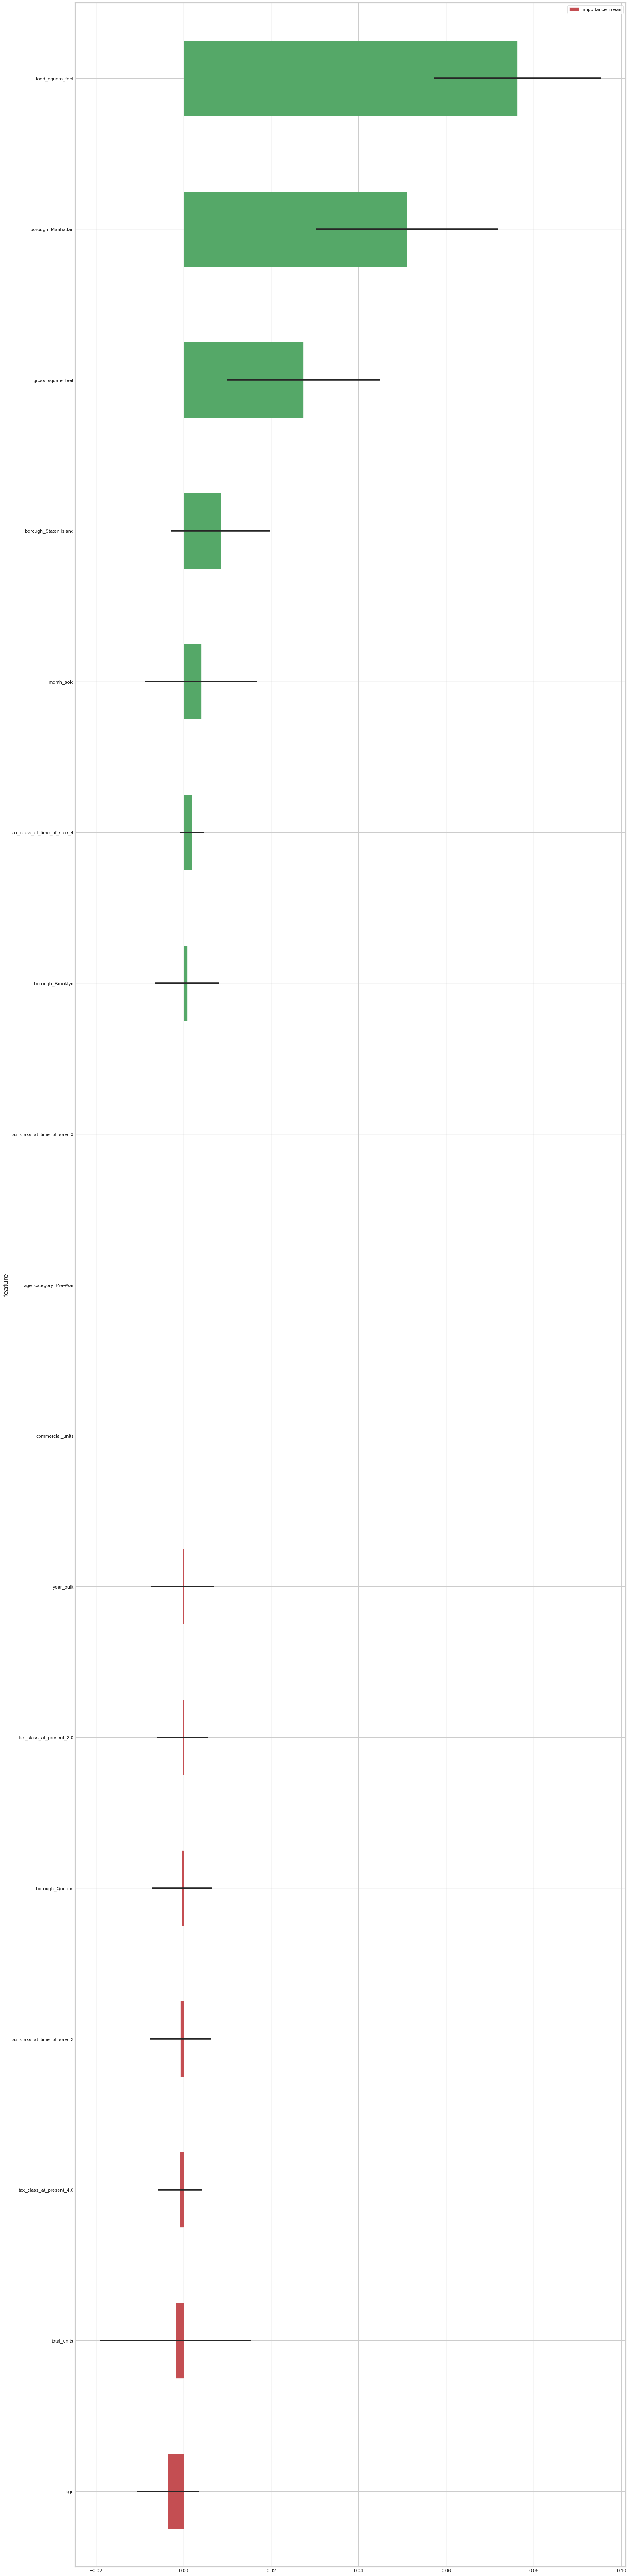

In [464]:
negative = importance_df[importance_df["importance_mean"] < 0]["feature"].tolist()
df.drop(negative, axis=1, inplace=True)
plot_importance(importance_df, figsize=(20, 100))
plt.show()

In [465]:
df.head()

,commercial_units,land_square_feet,gross_square_feet,sale_price,month_sold,borough_Brooklyn,borough_Manhattan,borough_Staten Island,tax_class_at_time_of_sale_3,tax_class_at_time_of_sale_4,age_category_Pre-War
4,0,-0,1,"6,625,000",0,False,True,False,False,False,True
7,0,-0,1,"3,936,272",0,False,True,False,False,False,True
8,0,-0,1,"8,000,000",1,False,True,False,False,False,True
10,0,-0,1,"3,192,840",0,False,True,False,False,False,True
13,0,0,1,"16,232,000",1,False,True,False,False,False,True


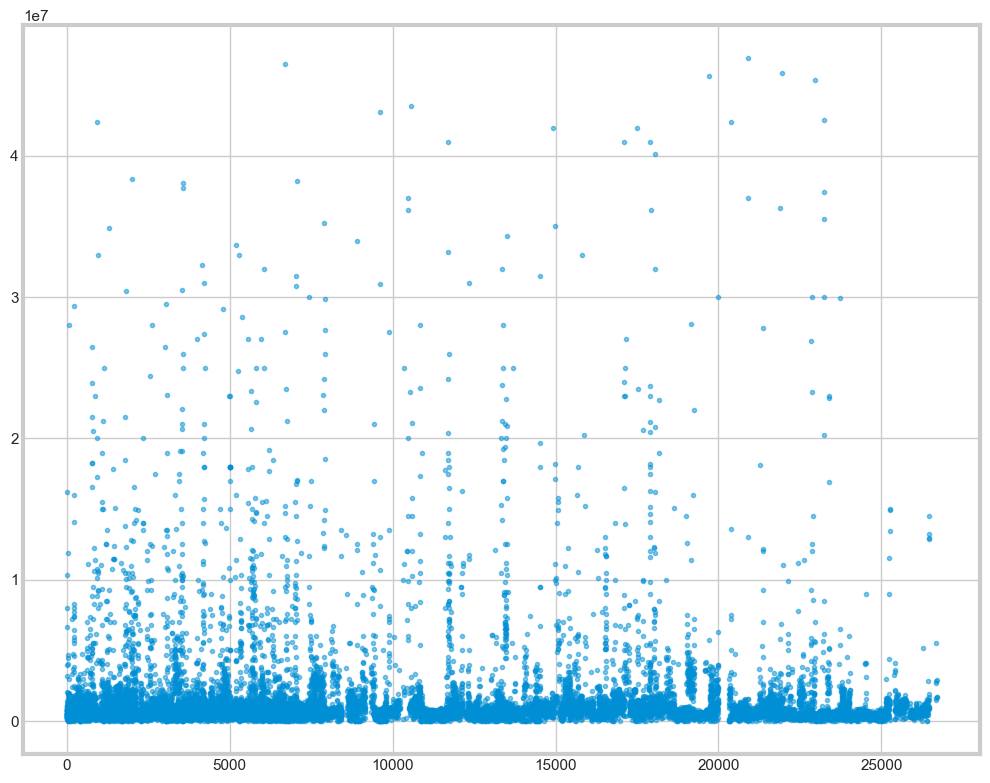

In [466]:
axes = df["sale_price"].plot(
    marker='.',
    alpha=0.5,
    linestyle='',
    figsize=(11, 9),
    subplots=True
)

In [467]:
df = df[(df['sale_price'] < 5e8) & (df['sale_price'] > 1e5)]


df["sale_price"].skew()

8.201131390125255

In [468]:
X_train, X_test, y_train, y_test  = df_split(df)

In [469]:
# Build and train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the sale prices on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
print(model.score(X_test, y_test))
print(mean_squared_error(y_test, y_pred) ** 0.5)

0.33660382396381705
2194952.1738623423


In [470]:
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.33660382396381705


In [471]:
model.coef_

array([ 0.00000000e+00,  1.44678865e+06,  1.54188447e+06, -3.16530969e+04,
        4.93159094e+05,  7.02313234e+06, -2.71761998e+05, -1.86264515e-09,
        1.79822354e+06, -2.49268281e+04])

<Axes: xlabel='sale_price'>

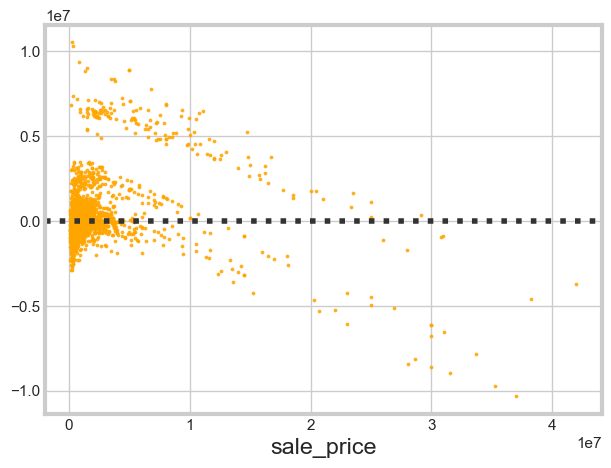

In [472]:
sns.residplot(x=y_test, y=y_pred, color="orange", scatter_kws={"s": 3})